## Imports

In [1]:
import matplotlib.pyplot as plt

from qiskit import Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit.visualization import plot_histogram

import pennylane as qml

from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import math

from tqdm.notebook import tqdm, trange

## Model definition

In [2]:
n_shots = 1

device = qml.device('default.qubit', wires=2, shots=n_shots)

In [3]:
@qml.qnode(device)
def circuit(x, parameters):
    #State Preparation
    for i in range(parameters.shape[1]):
        qml.RY(x[i], wires=i)
        qml.RY(x[i], wires=i)
    #Add layers
    for i in range(parameters.shape[0]):
        for j in range(parameters.shape[1]):
            qml.Rot(parameters[i, j, 0], parameters[i, j, 1], parameters[i, j, 2], wires=j)
            #qml.RX(parameters[i, j, 0], wires=j)
            #qml.RY(parameters[i, j, 1], wires=j)
            #qml.RZ(parameters[i, j, 2], wires=j)

        for j in range(parameters.shape[1]):
            qml.CNOT(wires=[0,1])
            qml.CNOT(wires=[1,0])
    #For measurement apply Pauli-Z to first qubit
    return qml.expval(qml.PauliZ(wires=0))

In [4]:
class Model:
    def __init__(self, n_features=2, n_layers=2):
        self.n_features = n_features
        self.n_layers = n_layers
        self.n_params = self.n_layers*self.n_features*3


    def __call__(self, x, parameters, bias):
        return circuit(x, parameters) + bias


## Loss Function

In [5]:
def cost(v, model, X, Y):
    out = np.array([model(x, v[0], v[1]) for x in X])
    return loss(Y, out)
    

def loss(y, out):
    return np.mean((y - out)**2)

## Data Generation

In [6]:
n_signal, n_background = 2000, 2000

data_signal = np.random.multivariate_normal([0, 0], [[0.8, -0.6], [-0.6, 0.8]], size=n_signal) + 0.5
data_background = np.random.multivariate_normal([0, 0], [[0.8, 0.6], [0.6, 0.8]], size=n_background) - 0.5



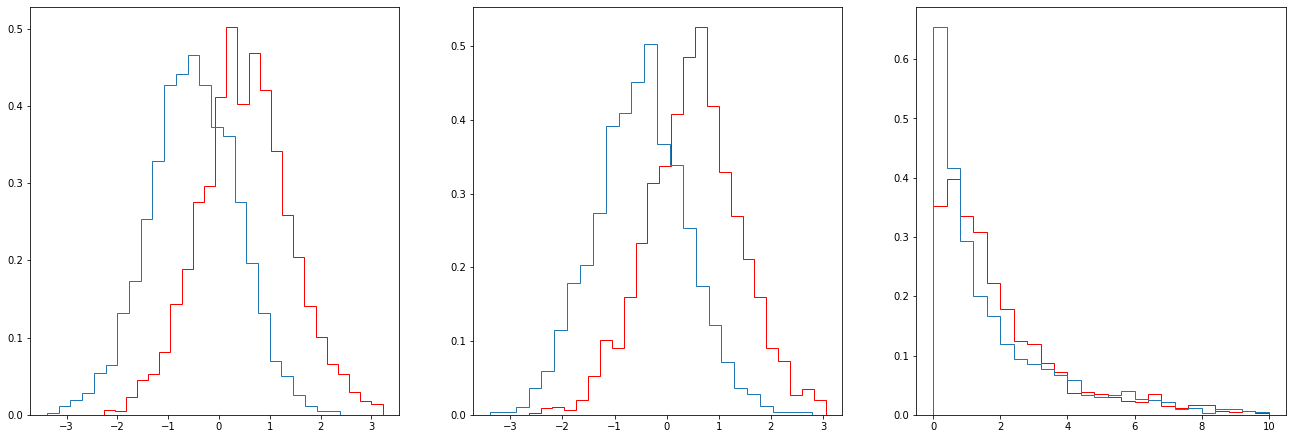

In [7]:
plt.figure(figsize=(22.5, 7.5))
plt.subplot(1, 3, 1)
plt.hist(data_signal[:,0], bins=25, histtype="step", color="red", density=True)
plt.hist(data_background[:,0], bins=25, histtype="step", density=True)

plt.subplot(1, 3, 2)
plt.hist(data_signal[:,1], bins=25, histtype="step", color="red", density=True)
plt.hist(data_background[:,1], bins=25, histtype="step", density=True)

plt.subplot(1, 3, 3)
plt.hist(np.sum(data_signal**2, axis=1), bins=25, histtype="step", color="red", range=(0,10), density=True)
plt.hist(np.sum(data_background**2, axis=1), bins=25, histtype="step", range=(0,10), density=True)
plt.show()

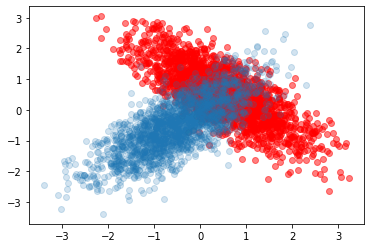

In [8]:
plt.scatter(data_signal[:,0], data_signal[:,1], color="red", alpha=0.5)
plt.scatter(data_background[:,0], data_background[:,1], alpha=0.2)
plt.show()

## Dataloader

In [9]:
data_train = np.concatenate([data_signal[:math.ceil(0.8*len(data_signal))], data_background[:math.ceil(0.8*len(data_background))]], axis=0)
labels_train = np.concatenate([np.ones(math.ceil(0.8*len(data_signal))), -np.ones(math.ceil(0.8*len(data_background)))], axis=0)
data_val = np.concatenate([data_signal[math.ceil(0.8*len(data_signal)):], data_background[math.ceil(0.8*len(data_background)):]], axis=0)
labels_val = np.concatenate([np.ones(math.floor(0.2*len(data_signal))), -np.ones(math.floor(0.2*len(data_background)))], axis=0)

In [10]:
class Dataloader:
    def __init__(self, data, labels, batchsize):
        assert len(data) == len(labels), "Require the same amount of labels as data"
        self.data = data
        self.labels = labels
        self.bs = batchsize
        
        self.permute()
        self.current = 0
        
    def permute(self):
        perm = np.random.permutation(len(self.data))
        self.data_perm = self.data[perm]
        self.labels_perm = self.labels[perm]
        
    def __len__(self):
        return math.ceil(len(self.data)/self.bs)
        
    def __next__(self):
        if self.current < len(self):
            lower, upper = self.current*self.bs, (self.current+1)*self.bs
            batch = self.data_perm[lower:upper], self.labels_perm[lower:upper]
            self.current += 1
            return batch
        else:
            self.permute()
            raise StopIteration
        
    def __get__(self, ind):
        return data[i], labels[i]
    
    def __iter__(self):
        self.current = 0
        self.permute()
        return self

## Training

In [11]:
# Training Parameters
n_epochs = 5
batch_size = 40
learning_rate = 0.005
beta1, beta2 = 0.9, 0.9


In [12]:
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)
model = Model()

#Initial params
var = (np.random.randn(model.n_layers, model.n_features, 3) * 0.01, 0.0)
trainloader = Dataloader(data_train, labels_train, batch_size)
valloader = Dataloader(data_val, labels_val, batch_size)

In [13]:
def validate(var):
    val_loss = 0
    for x, y in valloader:
        val_loss += cost(var, model, x, y)/len(valloader)
    return val_loss

In [14]:
for epoch in trange(n_epochs):
    for x, y in tqdm(trainloader, leave=False):
        var = opt.step(lambda v: cost(v, model, x, y), var)
    tqdm.write(f"Validation loss in epoch {epoch}: {validate(var)}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

Validation loss in epoch 0: 1.689854851981748


  0%|          | 0/80 [00:00<?, ?it/s]

Validation loss in epoch 1: 1.5499202295928236


  0%|          | 0/80 [00:00<?, ?it/s]

Validation loss in epoch 2: 1.4998482082809326


  0%|          | 0/80 [00:00<?, ?it/s]

Validation loss in epoch 3: 1.5648319527423364


  0%|          | 0/80 [00:00<?, ?it/s]

Validation loss in epoch 4: 1.465936208239314


## Validation

In [15]:
# Decision Regions
pixels = np.empty((100, 100))

for i, x in enumerate(np.linspace(-4, 4, 100)):
    for j, y in enumerate(np.linspace(-4, 4, 100)):
        pixels[i, j] = model(np.array([x,y]), var[0], var[1])

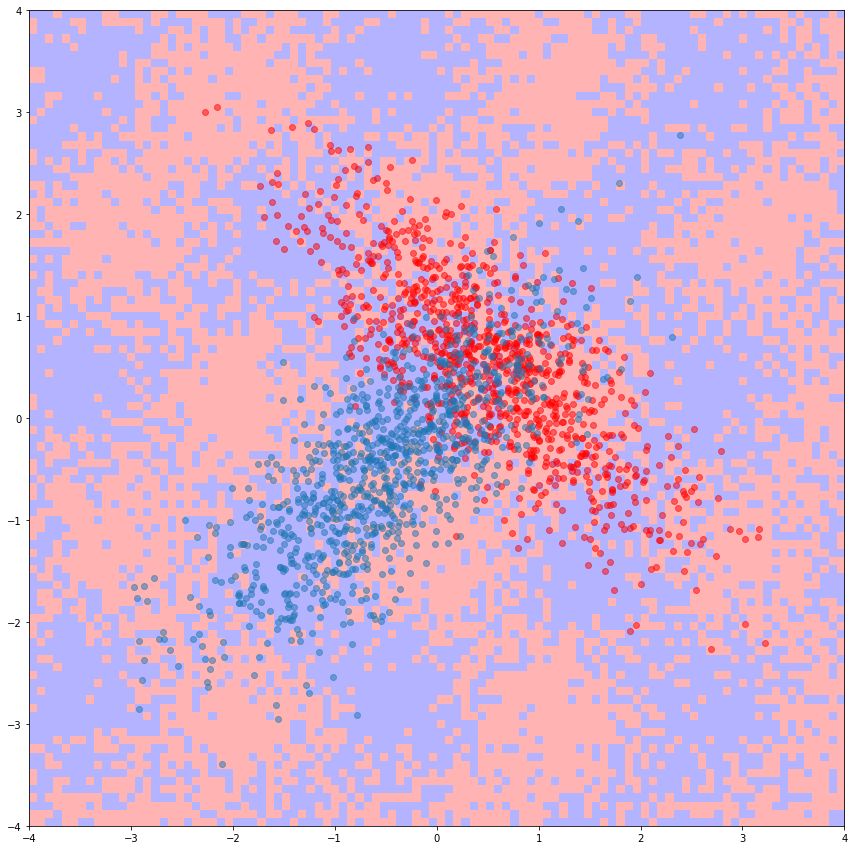

In [20]:
plt.figure(figsize=(15, 15))
plt.imshow(pixels, cmap="bwr", alpha=0.3, extent=[-4, 4, -4, 4])
plt.scatter(data_signal[:1000,0], data_signal[:1000,1], color="red", alpha=0.5)
plt.scatter(data_background[:1000,0], data_background[:1000,1], alpha=0.5)
plt.show()

In [17]:
# Accuracy
acc = 0.0
for x, y in tqdm(valloader):
    out = np.array([model(data, var[0], var[1]) for data in x])
    acc += np.sum(np.sign(y) == np.sign(out))/(len(valloader)*batch_size)
print("Validation accuracy %.2f %%" %(acc*100))

acc = 0.0
for x, y in tqdm(trainloader):
    out = np.array([model(data, var[0], var[1]) for data in x])
    acc += np.sum(np.sign(y) == np.sign(out))/(len(trainloader)*batch_size)
print("Train accuracy %.2f %%" %(acc*100))

  0%|          | 0/20 [00:00<?, ?it/s]

Validation accuracy 61.25 %


  0%|          | 0/80 [00:00<?, ?it/s]

Train accuracy 64.94 %
